# <center>Project MVP</center>
by: **Ibrahim Alzuhairi** and **Abdulaziz Alshehri**

## 1. Web Scraping

**Scraped datasets:**
* 1- **Calander** dataset which contains all holydaies, school begaining/ending, ramadan and national days in to two differant calenders Hijri and AD.
* 2- **Weather** dataset wich contains weather hourly information for the last 4 years (2018-2021).

**Additinal datasets:**
* 3-**Steps** dataset wich contain the number of steps that we are trying to predict along with the date and time for each observation.

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)

## 2. Loading Data

In [3]:
# loading
Steps0 = pd.read_csv('Steps.csv')
Calendar = pd.read_csv('Calendar.csv')
Sleep = pd.read_csv('Sleep_Schedule.csv')
Weather = pd.read_csv('weather.csv')

# 
Sleep.columns = Sleep.columns.str.strip()
Calendar.columns = Calendar.columns.str.strip()

# columns selection 
Steps0 = Steps0[['Date', 'Steps']]
Calendar = Calendar[['Date','AD_Month', 'AH_Month', 'Long_Vacation', 'Short_Vacation', 'Ramadan', 'Sch_Eid_Adha', 'Sch_Eid_Fatr', 'National_Day', 'National_Day_Ext', 'AD_WeekdayNum']]
Sleep = Sleep[['Date','Woke_Hour']]
Weather = Weather[['date', 'temp_min', 'temp_max', 'is_rain']]

# merge datasets
df = pd.merge(Steps0, Calendar,how='left',on='Date')
df = pd.merge(df, Sleep,how='left',on='Date')
df = pd.merge(df, Weather,how='left',left_on='Date',right_on='date')

# 
df.sort_values('Date', inplace=True)
del df['date']
del df['Date']
del df['Sch_Eid_Adha']
df['is_rain'] = df['is_rain'].astype('int')

In [4]:
df

,Steps,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,Woke_Hour,temp_min,temp_max,is_rain
0,3140,6,9,1,0,1,0,0,0,5,18,86,111,0
1,9810,6,9,1,0,1,0,0,0,6,20,88,113,0
2,6551,6,9,1,0,1,0,0,0,0,6,90,111,0
3,6107,6,9,1,0,1,0,0,0,1,6,88,113,0
4,2569,6,9,1,0,1,0,0,0,2,6,86,113,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,4454,9,2,0,0,0,0,0,0,3,3,73,100,0
1203,3702,9,2,0,0,0,0,0,0,4,6,73,100,0
1204,3939,9,2,0,0,0,0,0,0,5,8,77,104,0
1205,2847,9,2,0,0,0,0,0,1,6,4,77,102,0


## 3. Correlation Analysis

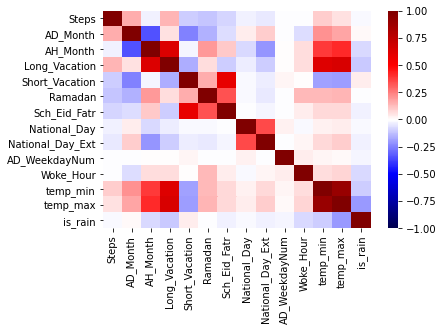

In [5]:
## correlation matrix,  and pair plot
df.corr()['Steps']
sns.heatmap(df.corr(), cmap='seismic', annot=False, vmin=-1, vmax=1);

## 4. Generate Lag values

In [6]:
for i in range(1,9):
    df['Lag'+str(i)] = df['Steps'].shift(i)
df = df.dropna()
df

,Steps,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,...,temp_max,is_rain,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8
8,3811,6,9,1,0,1,0,0,0,6,...,111,0,1756.0,743.0,2283.0,2569.0,6107.0,6551.0,9810.0,3140.0
9,2202,6,9,1,0,1,0,0,0,0,...,109,0,3811.0,1756.0,743.0,2283.0,2569.0,6107.0,6551.0,9810.0
10,11535,6,9,1,0,1,0,0,0,1,...,109,0,2202.0,3811.0,1756.0,743.0,2283.0,2569.0,6107.0,6551.0
11,10248,6,9,1,0,1,0,0,0,2,...,106,0,11535.0,2202.0,3811.0,1756.0,743.0,2283.0,2569.0,6107.0
12,10022,6,9,1,0,1,0,0,0,3,...,104,0,10248.0,11535.0,2202.0,3811.0,1756.0,743.0,2283.0,2569.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,4454,9,2,0,0,0,0,0,0,3,...,100,0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,2310.0,2378.0
1203,3702,9,2,0,0,0,0,0,0,4,...,100,0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,2310.0
1204,3939,9,2,0,0,0,0,0,0,5,...,104,0,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0
1205,2847,9,2,0,0,0,0,0,1,6,...,102,0,3939.0,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0


## 5. Normalization

In [7]:
Norm_df=(df-df.mean())/df.std()
Norm_df

,Steps,AD_Month,AH_Month,Long_Vacation,Short_Vacation,Ramadan,Sch_Eid_Fatr,National_Day,National_Day_Ext,AD_WeekdayNum,...,temp_max,is_rain,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8
8,0.077199,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,1.497814,...,1.077436,-0.185698,-0.552813,-0.862393,-0.390251,-0.302354,0.780624,0.916101,1.909126,-0.129858
9,-0.415612,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-1.497814,...,0.952312,-0.185698,0.076810,-0.552115,-0.861920,-0.389947,-0.302709,0.780178,0.912927,1.909052
10,2.442935,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-0.998542,...,0.952312,-0.185698,-0.416165,0.077325,-0.551660,-0.861598,-0.390282,-0.302927,0.777207,0.912829
11,2.048748,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,-0.499271,...,0.764625,-0.185698,2.443333,-0.415506,0.077743,-0.551350,-0.861828,-0.390481,-0.304276,0.777105
12,1.979528,-0.181938,0.650276,1.493300,-0.243183,3.427173,-0.142858,-0.050063,-0.139791,0.000000,...,0.639501,-0.185698,2.049015,2.443160,-0.415059,0.078030,-0.551649,-0.861929,-0.391699,-0.304404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,0.274140,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.000000,...,0.389252,-0.185698,0.578363,-0.251025,-0.272333,0.281085,0.238651,-0.789375,-0.383446,-0.362789
1203,0.043814,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.499271,...,0.389252,-0.185698,0.273816,0.578733,-0.250587,-0.272034,0.280600,0.238319,-0.789995,-0.383576
1204,0.116403,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,-0.139791,0.998542,...,0.639501,-0.185698,0.043414,0.274274,0.579122,-0.250289,-0.272395,0.280260,0.236160,-0.790135
1205,-0.218058,0.720727,-1.287162,-0.669099,-0.243183,-0.291542,-0.142858,-0.050063,7.147572,1.497814,...,0.514377,-0.185698,0.116027,0.043939,0.274681,0.579390,-0.250655,-0.272619,0.278037,0.236045


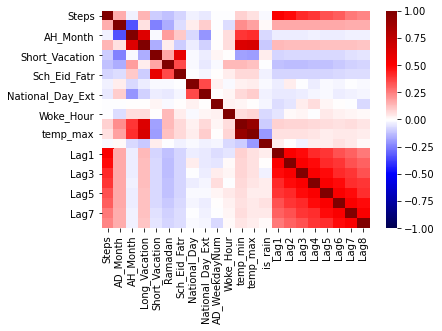

In [8]:
## correlation matrix,  and pair plot
df.corr()['Steps']
sns.heatmap(df.corr(), cmap='seismic', annot=False, vmin=-1, vmax=1);

## 6. Regularization

In [12]:
def regularization(X, y):
    
    # Grid Search
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    params = {'alpha': np.linspace(0.001, 100, num=100)}
    model = GridSearchCV(Lasso(), param_grid=params, cv=kf, return_train_score=False)

    return model

In [13]:
# split X and y
X = df.drop(['Steps'], axis=1)
y = df['Steps']

# kFold Grid Search
model = regularization(X, y)

# score model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)
print(f'model score : {model.best_estimator_.score(X_test, y_test)}')

model score : 0.35455582529900975


In [14]:
# eleminate columns with 0 coef
df = df.iloc[:,np.append([True], model.best_estimator_.coef_ != 0)]
df

,Steps,AD_Month,AH_Month,Long_Vacation,AD_WeekdayNum,Woke_Hour,temp_min,temp_max,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8
8,3811,6,9,1,6,6,93,111,1756.0,743.0,2283.0,2569.0,6107.0,6551.0,9810.0,3140.0
9,2202,6,9,1,0,6,82,109,3811.0,1756.0,743.0,2283.0,2569.0,6107.0,6551.0,9810.0
10,11535,6,9,1,1,12,81,109,2202.0,3811.0,1756.0,743.0,2283.0,2569.0,6107.0,6551.0
11,10248,6,9,1,2,10,84,106,11535.0,2202.0,3811.0,1756.0,743.0,2283.0,2569.0,6107.0
12,10022,6,9,1,3,10,81,104,10248.0,11535.0,2202.0,3811.0,1756.0,743.0,2283.0,2569.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,4454,9,2,0,3,3,73,100,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,2310.0,2378.0
1203,3702,9,2,0,4,6,73,100,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0,2310.0
1204,3939,9,2,0,5,8,77,104,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0,980.0
1205,2847,9,2,0,6,4,77,102,3939.0,3702.0,4454.0,5448.0,2739.0,2668.0,4474.0,4337.0
